# PRÁCTICA FINAL

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./Unemployment in America Per US State.csv')
df.head()

,FIPS Code,State/Area,Year,Month,Total Civilian Non-Institutional Population in State/Area,Total Civilian Labor Force in State/Area,Percent (%) of State/Area's Population,Total Employment in State/Area,Percent (%) of Labor Force Employed in State/Area,Total Unemployment in State/Area,Percent (%) of Labor Force Unemployed in State/Area
0,1,Alabama,1976,1,"2,605,000","1,484,555",57.0,"1,386,023",53.2,"98,532",6.6
1,2,Alaska,1976,1,"232,000","160,183",69.0,"148,820",64.1,"11,363",7.1
2,4,Arizona,1976,1,"1,621,000","964,120",59.5,"865,871",53.4,"98,249",10.2
3,5,Arkansas,1976,1,"1,536,000","889,044",57.9,"824,395",53.7,"64,649",7.3
4,6,California,1976,1,"15,621,000","9,774,280",62.6,"8,875,685",56.8,"898,595",9.2


Lo primero que haremos será comprender los datos de los que disponemos. Contamos con 11 variables:


- FIPS Code of State/Area: identificador del Estado
- Year: año
- Month: mes
- Total Civilian Non-Institutional Population in State/Area: Número total de civiles no institucionalizados que residen en el estado/zona.
- Total Civilian Labor Force in State/Area: Número total de civiles aptos para el empleo que residen en el estado/zona.
- Percent (%) of State/Area's Population: Porcentaje de civiles aptos para el empleo sobre el total de la población civil no institucionalizada.
- Total Employment in State/Area: Número total de civiles empleados actualmente en el estado/zona: Porcentaje de civiles actualmente empleados sobre el total de la población civil no institucionalizada.
- Percent (%) of Labor Force Employed in State/Area: Porcentaje de civiles actualmente empleados sobre el total de la población civil no institucionalizada.
- Total Unemployment in State/Area: Número total de civiles actualmente desempleados en el estado/zona.
- Percent (%) of Labor Force Unemployed in State/Area: Porcentaje de civiles actualmente desempleados sobre el total de la población civil no institucionalizada.

## PREPROCESO

Primero comprobamos los tipos de datos que tenemos y la presencia de nulos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29892 entries, 0 to 29891
Data columns (total 11 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   FIPS Code                                                  29892 non-null  int64  
 1   State/Area                                                 29892 non-null  object 
 2   Year                                                       29892 non-null  int64  
 3   Month                                                      29892 non-null  int64  
 4   Total Civilian Non-Institutional Population in State/Area  29892 non-null  object 
 5   Total Civilian Labor Force in State/Area                   29892 non-null  object 
 6   Percent (%) of State/Area's Population                     29892 non-null  float64
 7   Total Employment in State/Area                             29892 non-null  object 
 8   Percen

Observamos que todas las estadísticas civiles se almacenan con un tipo de dato objeto. Necesitamos convertirlas a un tipo de dato numérico para poder trabajar con ellas:

In [5]:
def objToInt(col):
    if df.dtypes[i]!='int64' and df.dtypes[i]!='float64':
        df[col]=df[col].str.replace(',','').astype('int64')

In [6]:
columns = df.columns
for i in range(2,len(columns)):
    objToInt(columns[i])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29892 entries, 0 to 29891
Data columns (total 11 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   FIPS Code                                                  29892 non-null  int64  
 1   State/Area                                                 29892 non-null  object 
 2   Year                                                       29892 non-null  int64  
 3   Month                                                      29892 non-null  int64  
 4   Total Civilian Non-Institutional Population in State/Area  29892 non-null  int64  
 5   Total Civilian Labor Force in State/Area                   29892 non-null  int64  
 6   Percent (%) of State/Area's Population                     29892 non-null  float64
 7   Total Employment in State/Area                             29892 non-null  int64  
 8   Percen

Para poder trabajar de mejor forma con las series temporales, creamos una columna con la fecha (en formato año/mes/día) combinando el mes y el año, para tener una marca de tiempo en una única columna:

In [7]:
df['Date']=pd.to_datetime(df['Year']*100 + df['Month'] ,format='%Y%m')
df.drop(columns=['Year','Month'],inplace=True)
df.head()

,FIPS Code,State/Area,Total Civilian Non-Institutional Population in State/Area,Total Civilian Labor Force in State/Area,Percent (%) of State/Area's Population,Total Employment in State/Area,Percent (%) of Labor Force Employed in State/Area,Total Unemployment in State/Area,Percent (%) of Labor Force Unemployed in State/Area,Date
0,1,Alabama,2605000,1484555,57.0,1386023,53.2,98532,6.6,1976-01-01
1,2,Alaska,232000,160183,69.0,148820,64.1,11363,7.1,1976-01-01
2,4,Arizona,1621000,964120,59.5,865871,53.4,98249,10.2,1976-01-01
3,5,Arkansas,1536000,889044,57.9,824395,53.7,64649,7.3,1976-01-01
4,6,California,15621000,9774280,62.6,8875685,56.8,898595,9.2,1976-01-01


In [8]:
def extraer_serie_temporal(df,estado):
    if estado != 'USA':
        serie_temporal = df[df['State/Area']==estado]
        desempleo = serie_temporal['Total Unemployment in State/Area'].values*100
        poblacion = serie_temporal['Total Civilian Labor Force in State/Area'].values
        serie_temporal[str('% Desempleo en '+ estado)] = desempleo/poblacion

        sns.set(style='whitegrid')
        sns.lineplot(x = "Date",
                y = str('% Desempleo en '+ estado),
                data = serie_temporal)

        return serie_temporal
    else:
        desempleo=pd.DataFrame(df.groupby('Date')[["Total Unemployment in State/Area"]].sum())
        poblacion=pd.DataFrame(df.groupby('Date')[["Total Civilian Labor Force in State/Area"]].sum())

        desempleo.reset_index(inplace=True)
        poblacion.reset_index(inplace=True)

        desempleo['Total Unemployment in State/Area']*=100

        serie_temporal=pd.DataFrame()
        serie_temporal['Date'] = df['Date'].unique()
        serie_temporal['% Unemployment in US'] = desempleo['Total Unemployment in State/Area']/poblacion["Total Civilian Labor Force in State/Area"]
        sns.set(style='whitegrid')

        sns.lineplot(x = "Date",
             y = "% Unemployment in US",
             data = serie_temporal)
        return serie_temporal

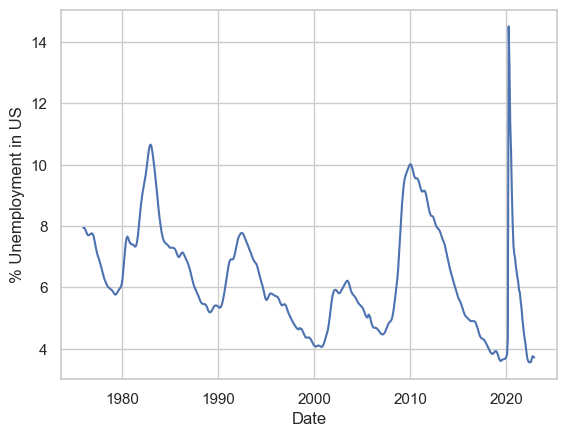

In [9]:
serie_temporal = extraer_serie_temporal(df, 'USA')

In [10]:
serie_temporal

,Date,% Unemployment in US
0,1976-01-01,7.941611
1,1976-02-01,7.941651
2,1976-03-01,7.916965
3,1976-04-01,7.849305
4,1976-05-01,7.779462
...,...,...
559,2022-08-01,3.579243
560,2022-09-01,3.688094
561,2022-10-01,3.758468
562,2022-11-01,3.742271


En el apartado anterior, hemos analizado el **Porcentaje de la Fuerza Laboral total de los Estados Unidos que está desempleada en cada mes**. Hacemos esto sumando el Total de Desempleo para cada estado y dividiendo eso por la suma del Total de la Fuerza Laboral Civil en todos los estados.

Posteriormente , generamos un gráfico que nos intente proporcionar algún tipo de descubrimiento en este caso tendencias en el desempleo.

Tras la generación anterior, no resaltamos ninguna tendencia en el desempleo, no se encuentra a priori estacionalidad, sin embargo descubrimos altos picos entorno a los años 1982, 2010 y 2020. Por ello, representamos gráficamente los 10 meses con un porcentaje más alto de desempleo en los EEUU de todos los tiempos.

In [11]:
top = serie_temporal.sort_values(by = '% Unemployment in US', ascending = False)[:10]
bottom = serie_temporal.sort_values(by = '% Unemployment in US', ascending = False)[-9:]
top

,Date,% Unemployment in US
531,2020-04-01,14.512050
532,2020-05-01,13.262448
533,2020-06-01,11.335550
84,1983-01-01,10.658533
83,1982-12-01,10.631486
85,1983-02-01,10.596150
82,1982-11-01,10.521718
534,2020-07-01,10.471440
86,1983-03-01,10.454415
81,1982-10-01,10.336860


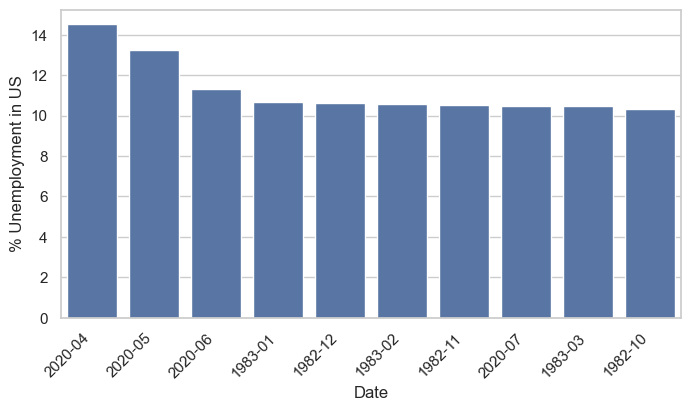

In [12]:
fig, ax = plt.subplots(figsize = (8,4))    
fig = sns.barplot(x = "Date", y = "% Unemployment in US", data = top, 
                  ax=ax)

x_dates = top['Date'].dt.strftime('%Y-%m')
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

plt.show()

Tras la representación, no es algo sorprendente, puesto que hemos determinado en esencia que las tasas de desempleo más altas corresponden al año 2020.

Tras darnos cuenta que es algo lógico, puesto que fue la era del Covid-19. La propagación inicial de la enfermendad suposo el despido masivo, ya que muchas empresas se vieron afectadas y encontraron grandes dificultades para desarrollar sus servicios u operaciones.


Para ello, pensamos en qué estados fueron los más afectados durante el periodo comprendido y poder llevar a cabo políticas que nos permitan cómo mejorar en un futuro estas grandes tasas de desempleo.

*ÉPOCA DEL COVID-19*

Para abordar esta situación, hemos considerado generar un nuevo dataframe, que contiene las tasas mensuales de desempleo desde abril hasta julio de 2020 para cada uno de los estados o áreas.

El parámetro *date* determinará el valor de la fecha para cual deseamos obtener las tasas de desempleo, por lo que almacenamos estas tasas en una columna denotada como *newMonth*.

In [13]:
covid_data = pd.DataFrame()
covid_data['States']=df['State/Area'].unique()

def addMonth(date, colname):
    newMonth = pd.DataFrame(df.loc[df['Date']==date,'Percent (%) of Labor Force Unemployed in State/Area'])
    newMonth.reset_index(inplace = True, drop = True)
    covid_data[colname] = newMonth

In [14]:
date = ['2020-04-01','2020-05-01','2020-06-01','2020-07-01']
months = ['Abril','Mayo','Junio','Julio']
for i in range(4):
    addMonth(date[i],months[i])
covid_data.head()

,States,Abril,Mayo,Junio,Julio
0,Alabama,13.8,10.4,8.6,7.5
1,Alaska,11.8,11.9,11.4,11.3
2,Arizona,13.8,11.2,9.7,8.9
3,Arkansas,10.1,8.9,7.9,7.3
4,California,16.1,15.7,13.8,13.2


Una vez obtenemos el nuevo conjunto de datos, podemos realizar una función que nos permita llevar a cabo el estudio de cuáles son los principales estados que han sufrido un mayor tasa de desempleo.

Mostramos los 10 primeros más afectados.

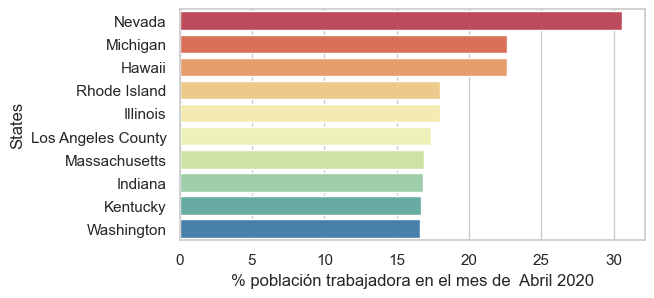

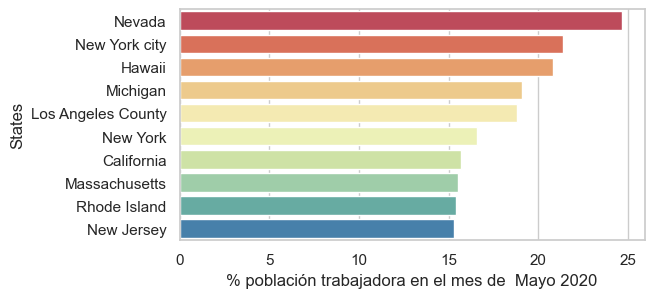

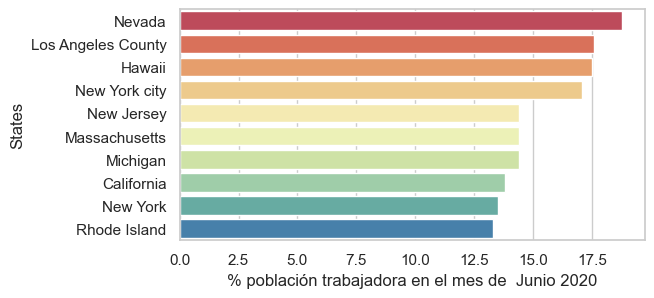

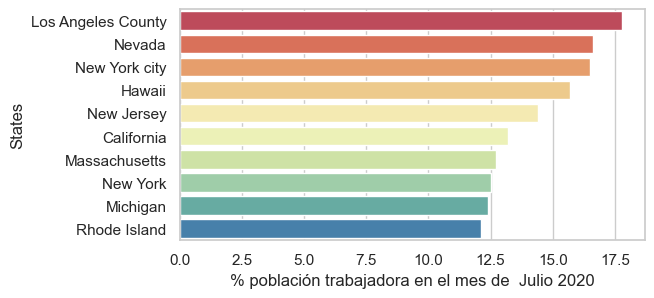

In [15]:
def monthPlot(month):
    plt.figure(figsize = (6,3))    
    fig = sns.barplot(y = "States", 
                      x = month, 
                      data = covid_data, 
                      order = covid_data.sort_values(by = month, ascending = False).States.head(10),
                      orient = 'h',
                      palette = ('Spectral'))
    fig.set(xlabel = str('% población trabajadora en el mes de  ' + month + ' 2020'))
for i in range(4):
    monthPlot(months[i])


Podemos extraer conocimiento a partir de estos gráficos:
- El estado de Nevada parece ser el más afectado de manera global de todos los estados, sufriendo el mayor % de desempleo, de manera general.

- Vemos como Los Angeles Country, al principio comienza con un porcentaje menor % , colocándose a finales de esta etapa como el estado con mayor % de desempleo , lo que podría conllevar a que el número de casos de la enfermedad y el avance de la misma en ese estado haya sido peor que en el resto, lo que podríamos determinar en esencia como mejorar la situación de la enfermedad y así tratar de paliar el desempleo en la ciudad.

Podemos observar que estos estados, cuyas tasas de desempleo eran mayor al 10% , tienen una fracción considerable de civiles que estaban desempleados, y por ello vamos a ver cuánto contribuyeron estos estaados al nº TOTAL de civiles desempleados en el país durante los meses dados. El propósito de ello, puede ser llevar a cabo el establecimiento de fondos o recursos basados en necesidades, es decir, cómo repartir la economía general del país en aquellos estados cuya situación sea peor que en el resto.

Para ello crearemos una función que calcule la suma total de los desempleados en un mes dado, los nombre de los 10 estados con tasas de desempleo más altas , la suma total de civiles para esos 10 estados y el porcentaje de ciudadnos desempleados en EEUU que proviene de los 10 estados con las tasas de desempleo más elevadas.

In [16]:
def fracTop(date,month):
    temp = int(df.loc[df['Date']== date][['Total Unemployment in State/Area']].sum())
    sort = list(covid_data.sort_values(by = month, ascending = False).States.head(10))
    unemp_top=int(df.loc[(df['Date']==date) & (df['State/Area'].isin(sort))][['Total Unemployment in State/Area']].sum())
    var = unemp_top*100/temp
    
    explode = [0,0.1]
    keys = ['Resto de estados','Top 10 estados con mayor desempleo']
    data = [100-var,var]
    color = sns.color_palette('dark')
    
    plt.figure(figsize=(6,3))
    plt.pie(data, 
            labels = keys, 
            colors = color, 
            explode = explode, 
            autopct='%.02f%%')
    
    plt.title(str('Conjunto de civiles desempleados en el mes de  '+ month +' 2020:'))
    plt.show()
      
    
    print("El top 10 de estados comprende el  " + "{:.2f}".format(var) + " del porcentaje de todos los civiles desempleados en la población activa de EE.UU. en el mes de "+ month +" 2020\n\n\n\n")


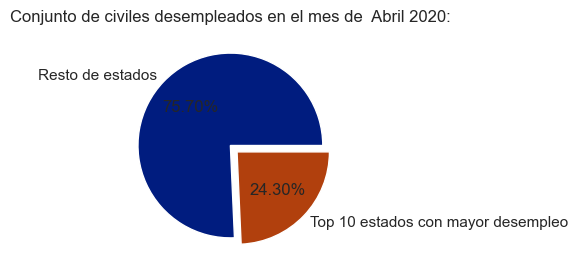

El top 10 de estados comprende el  24.30 del porcentaje de todos los civiles desempleados en la población activa de EE.UU. en el mes de Abril 2020






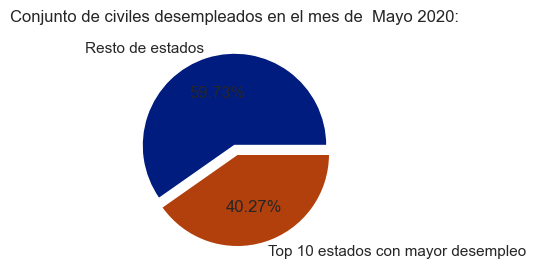

El top 10 de estados comprende el  40.27 del porcentaje de todos los civiles desempleados en la población activa de EE.UU. en el mes de Mayo 2020






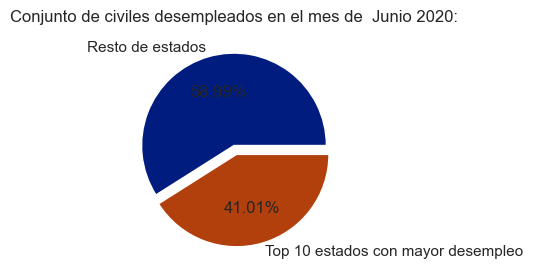

El top 10 de estados comprende el  41.01 del porcentaje de todos los civiles desempleados en la población activa de EE.UU. en el mes de Junio 2020






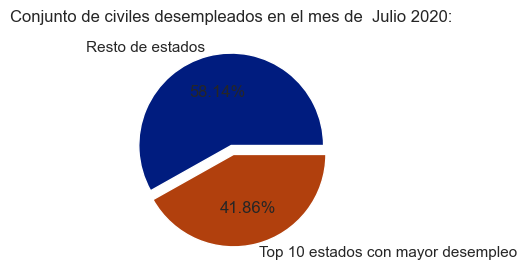

El top 10 de estados comprende el  41.86 del porcentaje de todos los civiles desempleados en la población activa de EE.UU. en el mes de Julio 2020






In [17]:
for i in range(len(date)):
    fracTop(date[i],months[i])

Resulta notable que, a pesar de que en abril de 2020 se registraron algunas de las tasas de desempleo más elevadas a nivel estatal, los 10 estados principales tienen una participación mínima en el número total de civiles desempleados en los Estados Unidos durante esos cuatro meses. Contribuyen apenas con una cuarta parte del total de civiles desempleados, mientras que en los meses subsiguientes representan más del 40% del total. Esta discrepancia podría atribuirse al hecho de que dos áreas densamente pobladas, concretamente Nueva York y California, ingresaron al top 10 a partir de mayo.

In [18]:
X = serie_temporal['% Unemployment in US']
testX = serie_temporal['% Unemployment in US'].iloc[-30:]
trainX = serie_temporal['% Unemployment in US'].iloc[:-30]

In [19]:
def mean_absolute_percentage_error_func(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    print('Evaluation metric results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error_func(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

**MODELO PARA REALIZAR PREDICCIONES**

Este modelo, es uno de los modelos básicos de los algoritmos de suavizado exponencial. Este método se puede utilizar para predecir series que no presentan tendencias o estacionalidad. Es decir, asume que no tienen ruido, nivel , estacionalidad y tendencia. 

Asume que la serie tiene:

- Level
- No trends
- No seasonality
- Noise


Además , cuenta con un parámetro que podemos optimizar , conocido como 

    smooting_level(float, optional)

Para ello, hemos usado una búsqueda , para saber cuál es el mejor de los parámetros

In [21]:
resu = []
temp_list = []

for i in [0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]:
    fit_v = SimpleExpSmoothing(np.asarray(trainX)).fit(i)
    fcst_pred_v = fit_v.forecast(len(testX))
    rmse = np.sqrt(metrics.mean_squared_error(testX, fcst_pred_v))
    temp_list.append({'smoothing parameter': i, 'RMSE': rmse})

# Construir DataFrame fuera del bucle
temp_df = pd.DataFrame(temp_list)
temp_df.sort_values(by=['RMSE'])


,smoothing parameter,RMSE
1,0.1,2.036630
0,0.0,3.151583
2,0.2,3.380377
3,0.3,4.667840
4,0.4,5.609782
5,0.5,6.215814
10,1.0,6.245937
9,0.9,6.432878
6,0.6,6.539038
8,0.8,6.584905


Obtenemos que el mejor es aquel en el que el RMSE tiene un valor más bajo, que es el caso de 0.1

In [22]:
SES = SimpleExpSmoothing(np.asarray(trainX))
fit_SES_auto = SES.fit(optimized= True, use_brute = True)

fcst_auto_pred = fit_SES_auto.forecast(len(testX))
timeseries_evaluation_metrics_func(testX, fcst_auto_pred)

Evaluation metric results: 
MSE is : 39.0117253988276
MAE is : 5.9809668001031895
RMSE is : 6.245936711080861
MAPE is : 133.3715078076171
R2 is : -11.041542248923504



In [23]:
fit_SES_auto.summary()

Dep. Variable:,endog,No. Observations:,534
Model:,SimpleExpSmoothing,SSE,114.161
Optimized:,True,AIC,-819.848
Trend:,None,BIC,-811.288
Seasonal:,None,AICC,-819.773
Seasonal Periods:,None,Date:,"Mon, 18 Dec 2023"
Box-Cox:,False,Time:,16:47:20
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,7.9416115,l.0,False


In [24]:
df_fcst_auto_pred = pd.DataFrame(fcst_auto_pred, columns=['Close_auto_search'])
df_fcst_auto_pred["new_index"] = range(len(trainX), len(X))
df_fcst_auto_pred = df_fcst_auto_pred.set_index("new_index")

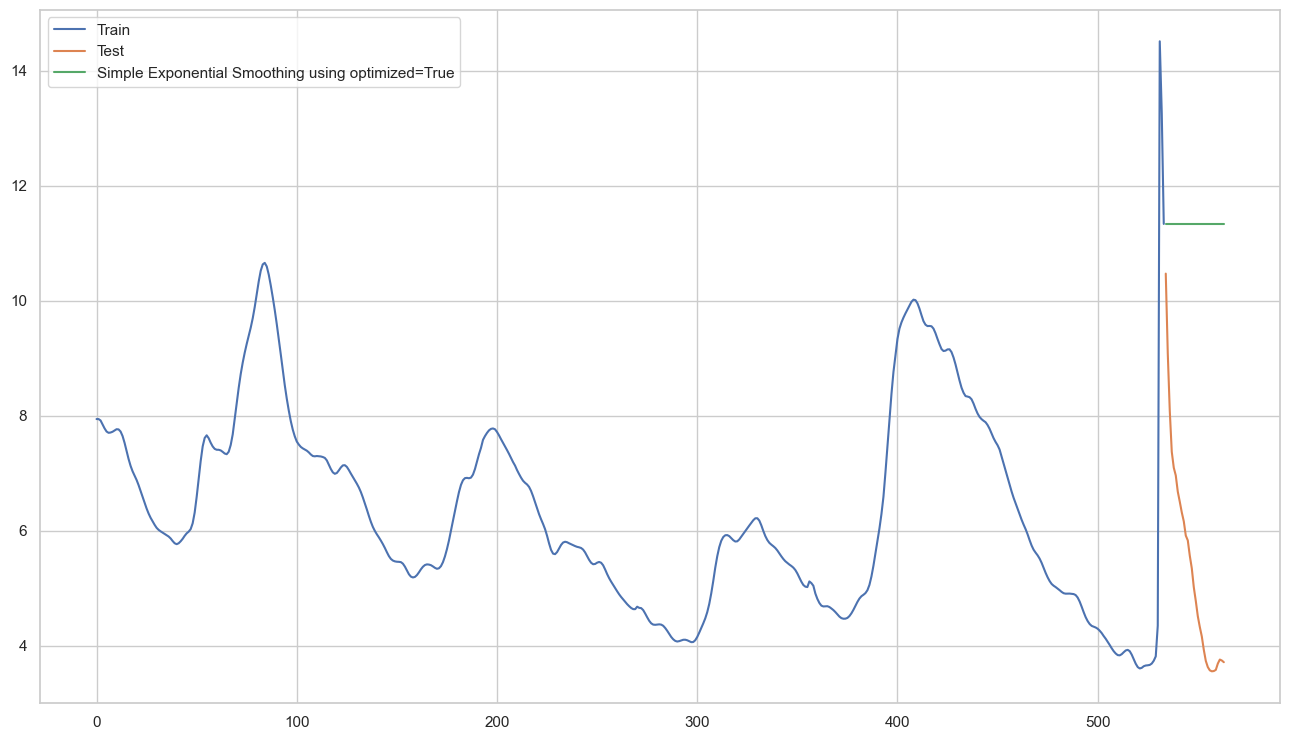

In [25]:
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(trainX, label='Train')
plt.plot(testX, label='Test')
plt.plot(df_fcst_auto_pred, label='Simple Exponential Smoothing using optimized=True')
plt.legend(loc='best')
plt.show()

In [26]:
param_grid_DES = {'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90], 
                  'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
                  'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
                  'damped': [True, False]}
pg_DES = list(ParameterGrid(param_grid_DES))

In [27]:
df_results_DES = pd.DataFrame(columns=['smoothing_level', 'smoothing_slope', 'damping_slope', 'damped', 'RMSE','R²'])

df_results_DES = pd.DataFrame(columns=['smoothing_level', 'smoothing_slope', 'damping_slope', 'damped', 'RMSE', 'R²'])
temp_list_DES = []

for a, b in enumerate(pg_DES):
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')

    fit_Holt = Holt(trainX, damped=damped).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope=damping_slope, optimized=False)
    fcst_gs_pred_Holt = fit_Holt.forecast(len(testX))

    df_pred = pd.DataFrame(fcst_gs_pred_Holt, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(testX, df_pred.Forecasted_result))
    r2 = metrics.r2_score(testX, df_pred.Forecasted_result)

    temp_list_DES.append({'smoothing_level': smoothing_level, 'smoothing_slope': smoothing_slope, 'damping_slope': damping_slope, 'damped': damped, 'RMSE': RMSE, 'R²': r2})

# Construir DataFrame fuera del bucle
df_results_DES = pd.DataFrame(temp_list_DES)


df_results_DES.sort_values(by=['RMSE','R²']).head(4)

,smoothing_level,smoothing_slope,damping_slope,damped,RMSE,R²
726,0.9,0.7,0.9,True,0.614022,0.883626
718,0.8,0.8,0.9,True,0.689884,0.853094
647,0.9,0.9,0.8,True,0.795258,0.804790
646,0.9,0.8,0.8,True,1.382898,0.409707


In [28]:
df_results_DES.to_csv('df_results_DES.csv')

In [29]:
best_values_DES = df_results_DES.sort_values(by=['RMSE','R²']).head(1)
best_values_DES

,smoothing_level,smoothing_slope,damping_slope,damped,RMSE,R²
726,0.9,0.7,0.9,True,0.614022,0.883626


In [30]:
smoothing_level_value_DES = best_values_DES['smoothing_level'].iloc[0]
smoothing_slope_value_DES = best_values_DES['smoothing_slope'].iloc[0]
damping_slope_value_DES = best_values_DES['damping_slope'].iloc[0]
damped_setting_DES = best_values_DES['damped'].iloc[0]

In [31]:
print("smoothing_level_value_DES: ", smoothing_level_value_DES)
print("smoothing_slope_value_DES: ", smoothing_slope_value_DES)
print("damping_slope_value_DES: ", damping_slope_value_DES)
print("damped_setting_DES: ", damped_setting_DES)

smoothing_level_value_DES:  0.9
smoothing_slope_value_DES:  0.7
damping_slope_value_DES:  0.9
damped_setting_DES:  True


In [32]:
DES = Holt(trainX,damped=damped_setting_DES)
fit_Holt = DES.fit(smoothing_level=smoothing_level_value_DES, smoothing_slope=smoothing_slope_value_DES, 
                   damping_slope=damping_slope_value_DES ,optimized=False)

fcst_gs_pred_Holt = fit_Holt.forecast(len(testX))
timeseries_evaluation_metrics_func(testX, fcst_gs_pred_Holt)

Evaluation metric results: 
MSE is : 0.3770230609245565
MAE is : 0.46070004279632176
RMSE is : 0.6140220361880806
MAPE is : 8.418807959640299
R2 is : 0.8836262925946377



In [33]:
DES = Holt(trainX)
fit_Holt_auto = DES.fit(optimized= True, use_brute = True)

fcst_auto_pred_Holt = fit_Holt_auto.forecast(len(testX))
timeseries_evaluation_metrics_func(testX, fcst_auto_pred_Holt)

Evaluation metric results: 
MSE is : 39.020177198835384
MAE is : 5.981577852847975
RMSE is : 6.2466132583052865
MAPE is : 133.38605376777426
R2 is : -11.044151021179351



In [34]:
fit_Holt_auto.summary()

Dep. Variable:,% Unemployment in US,No. Observations:,534
Model:,Holt,SSE,114.161
Optimized:,True,AIC,-815.850
Trend:,Additive,BIC,-798.728
Seasonal:,None,AICC,-815.690
Seasonal Periods:,None,Date:,"Mon, 18 Dec 2023"
Box-Cox:,False,Time:,16:47:25
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


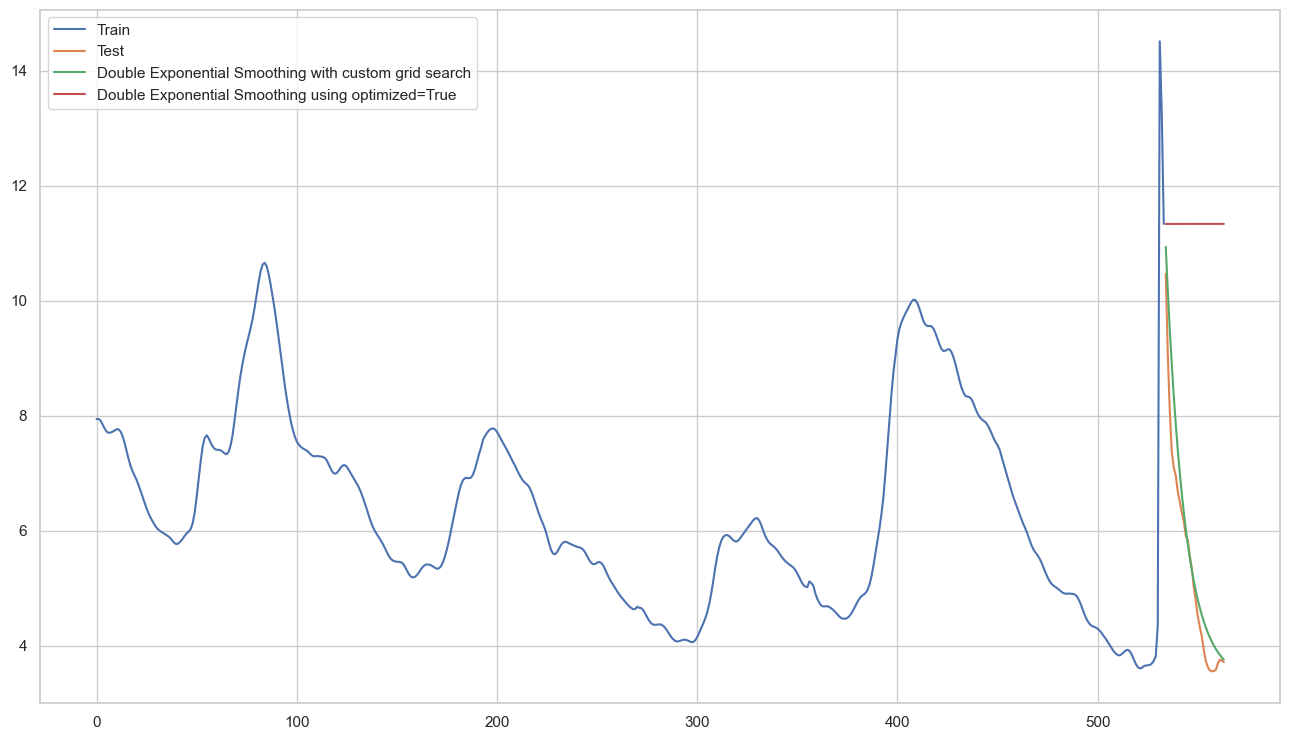

In [35]:
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(trainX, label='Train')
plt.plot(testX, label='Test')
plt.plot(fcst_gs_pred_Holt, label='Double Exponential Smoothing with custom grid search')
plt.plot(fcst_auto_pred_Holt, label='Double Exponential Smoothing using optimized=True')
plt.legend(loc='best')
plt.show()

In [36]:
serie_temporal

,Date,% Unemployment in US
0,1976-01-01,7.941611
1,1976-02-01,7.941651
2,1976-03-01,7.916965
3,1976-04-01,7.849305
4,1976-05-01,7.779462
...,...,...
559,2022-08-01,3.579243
560,2022-09-01,3.688094
561,2022-10-01,3.758468
562,2022-11-01,3.742271


Epoch 1/50
15/15 [==============================] - 1s 6ms/step - loss: 0.0226
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 5/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 6/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 7/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 8/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 9/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 10/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 11/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 12/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 13/50
15/15 [==============================

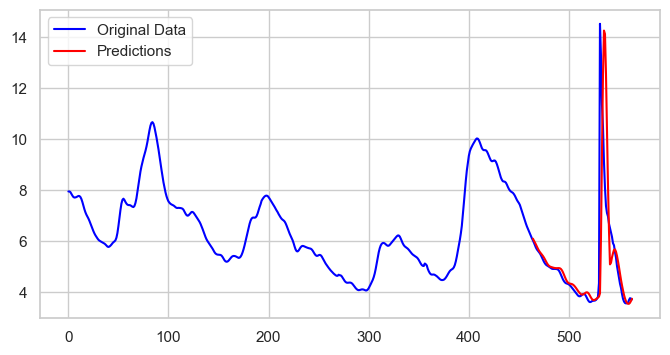

In [37]:
data = serie_temporal['% Unemployment in US'].values.reshape(-1,1)

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Preparar los datos para el modelo
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

# Definir los parámetros
time_steps = 10  # Puedes ajustar este valor según tus necesidades
train_size = 464

# Crear conjuntos de entrenamiento y prueba
train_data = data_normalized[:train_size, :]
test_data = data_normalized[train_size - time_steps:, :]

X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape para que sea compatible con la entrada de LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Hacer predicciones
predicted_data = model.predict(X_test)
predicted_data = scaler.inverse_transform(predicted_data)

# Deshacer la normalización para los datos de prueba
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

plot_data = serie_temporal.iloc[train_size:].copy()
plot_data['Predictions'] = predicted_data

# Plotear los resultados
plt.figure(figsize=(8, 4))
plt.plot(serie_temporal['% Unemployment in US'], label='Original Data', color='blue')
plt.plot(plot_data['Predictions'], label='Predictions', color='red')
plt.legend()
plt.show()


In [38]:
mae = mean_absolute_error(y_test, predicted_data)
print(f'Mean Absolute Error (MAE): {mae}')
mse = mean_squared_error(y_test, predicted_data)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 0.5861289648122778
Mean Squared Error (MSE): 2.789771663029933
Root Mean Squared Error (RMSE): 1.6702609565663484


In [39]:
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1.6702609565663484
